### An Open Data Story: The Python Journey that almost took me from a Coffee Shop to a Bike Share Rack
<b>by Gareth Cull</b>

Last Friday was anything but your typical Friday. Waking up early to the sweet sounds of raccoons pillaging garbage is never the way to start one's day.  But there I was, lying in bed...thinking about my garbage...first thing in the morning. I begrudgingly got up, walked down the stairs and over a present that my cat decided to leave me during the middle of the night. I opened the front door and to my surprise, everything was still in tact! What a relief. I got lucky there, but school drop-offs were next, and if history is any indicator, this could be anything but smooth.

Three quarters of the way to school drop-off I realized had left my mobile at home on my bedside table.

'Probably a good thing,' I thought to myself. 'They do say it is good to disconnect from the notification bliss we receive every now and then. Plus it'll reduce my app usage stats, and according to Apple that can only be a good thing. However, I do love listening to music while I walk around...maybe i'll go back and get it.'

After I dropped off the kids, I went back to the house, grabbed my phone and  laptop and then strolled down the Danforth pondering what to do with my day. I came across this cool little coffee shop called Red Rocket Coffee.

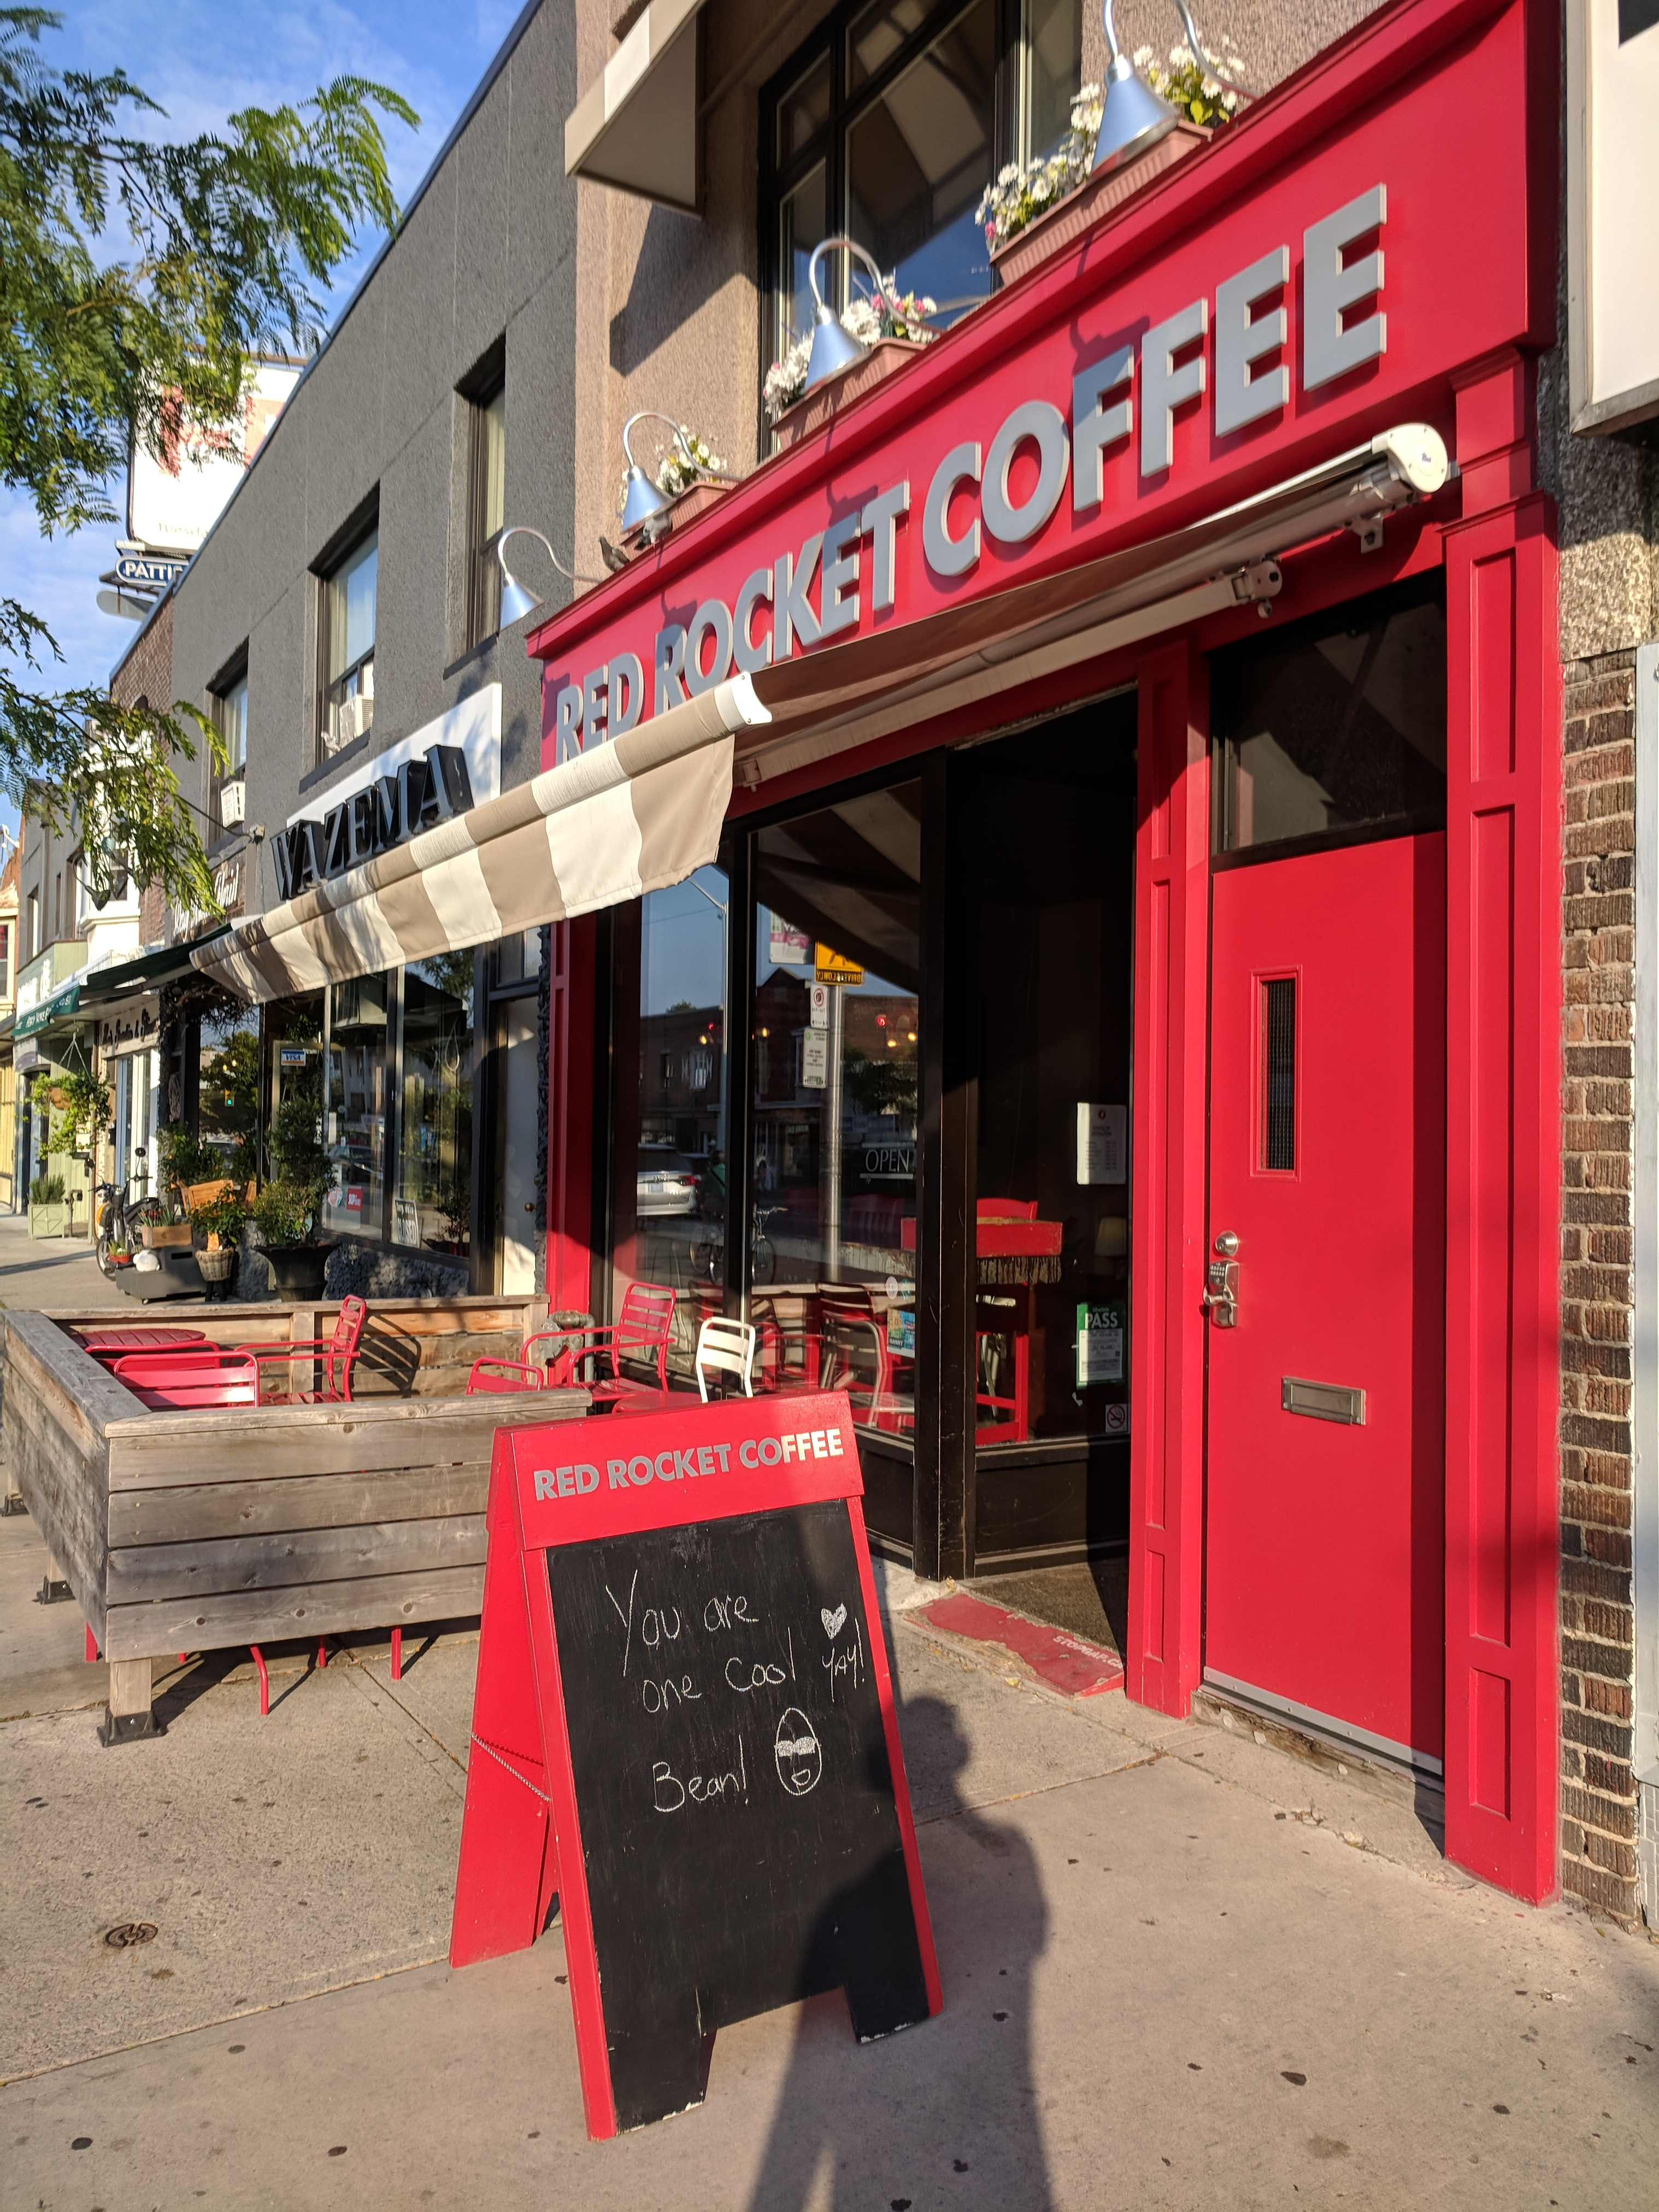

In [114]:
from IPython.display import Image
Image("red_rocket.jpg")

This place was sweet! I will most definitely hack from this coffee shop today. So, I ordered a flat white and a cookie and then settled down to explore the wonderful world of python.

It wasn't long before I figured out how to extract and visualize my ride sharing history on a folium map. I'm not sure why I really decided to do this, but I kind of wanted to know what this data would look like. This was kinda neat! Some people may not necessarily share this info, but it's interesting to be able to figure out how to visualize multiple routes on a map. I wonder what else I can do?

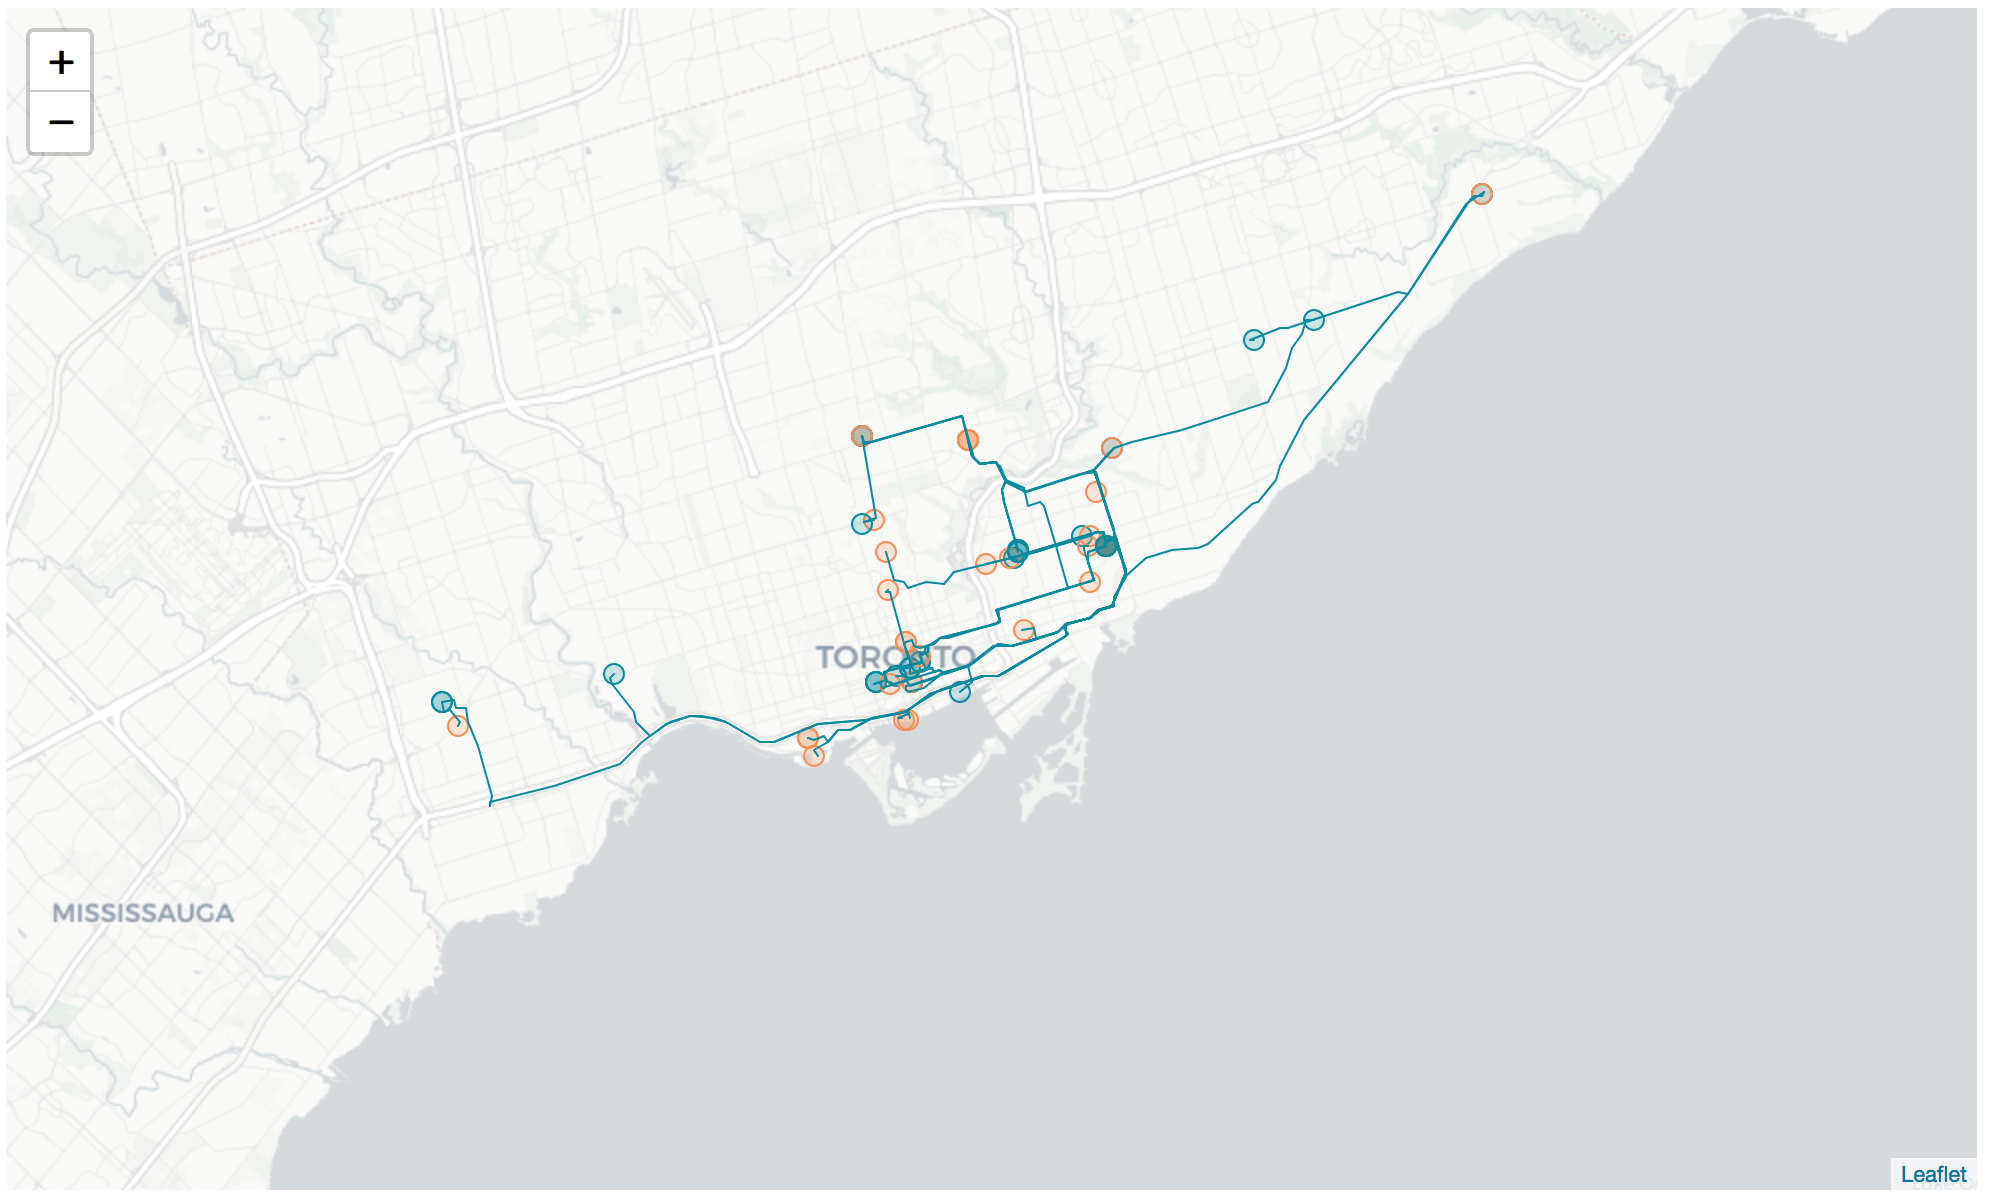

In [113]:
from IPython.display import Image
Image("myridehistory.png")

Feeling pretty proud of the map I made, I decided to go home and observe a new tradition I picked up over the summer while in Spain - the Siesta. With that mid afternoon nap calling my name, I quickly packed up my bags and was halfway out the door when suddenly I realized the long walk home was perhaps a little too long.

'Maybe I'll just rent a bike,' I thought to myself. 'I could just Google directions to find the nearest one...'

OR...

'I could build a jupyter notebook leveraging Open Data from the City of Toronto and use python to help me determine which station is the closest!'

So there i was, the proverbial fork in the road. A decision needed to be made.

On one side: There was Google, with all the magical things that it can do.

On the other side: A python rabbit hole potentially so deep, I may need a blue pill just to get out of it.

Ok, the python rabbit does sound like fun and I do have some time at the moment, so why not.
The Game Plan

Before I get started, let's put together a quick game plan for what needs to be done. I'll need to:

- Import Relevant Libraries<br/>
- Import Data from the City's Bike Share Program (Bike Stations & Availability)<br/>
- Determine my current latitude and longitude while at the coffee shop<br/>
- Create a function to determine the closest stations by latitude and longitude<br/>
- Create a Function that determines bike availability at the closest stations<br/>
- Plot myself and the closest stations on a folium map<br/>
- Plot route to the closest station with bike availability<br/>
- Leave coffee shop and rent the bike!<br/>

Ok. The plan is ready. Let's get started!

### Import Libraries

In [1]:
import pandas as pd
import folium
from folium import plugins
import geopy.distance
from datetime import datetime
import openrouteservice                 # Used to get lat / longs in between starting and ending lat / long
from openrouteservice import convert

### Import Data

Ok. Now let's import a few open datasets from the City of Toronto's website:


1. [A json list of Bike Share Stations](https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information)

2. [A json list of each Bike Share Station's status](https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_status) (ie. how many bikes each have available)

#### Let's read each json file and store into a dataframe. 

First up - retreiving information about all bike share stations in the City of Toronto

In [2]:
stations = pd.read_json('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information', lines=True)

In [3]:
# Let's see what this looks like.
stations.head()

data  last_updated  ttl
0  {'stations': [{'station_id': 7000, 'name': 'Fo...    1537534651    3

Ok. We are going to need to parse what is in stations['data'] to get at the information. But first let's see when this data was last updated. 

In [4]:
from datetime import datetime
datetime.utcfromtimestamp(1537476761).strftime('%Y-%m-%d %H:%M:%S')

'2018-09-20 20:52:41'

#### Let's store what is in stations['data'] into its own df called station attributes (station_attr)

In [5]:
station_attr = stations['data'][0]['stations']

In [6]:
station_attr = pd.DataFrame(station_attr)

In [7]:
station_attr.head()

address  capacity  is_valet_station        lat  \
0    Fort York  Blvd / Capreol Crt        31             False  43.639832   
1  Lower Jarvis St / The Esplanade        15             False  43.647992   
2       St. George St / Bloor St W        19             False  43.667333   
3         Madison Ave / Bloor St W        15             False  43.667158   
4          University Ave / Elm St        11             False  43.656518   

         lon                             name  \
0 -79.395954    Fort York  Blvd / Capreol Crt   
1 -79.370907  Lower Jarvis St / The Esplanade   
2 -79.399429       St. George St / Bloor St W   
3 -79.402761         Madison Ave / Bloor St W   
4 -79.389099          University Ave / Elm St   

                          rental_methods  station_id  
0  [KEY, CREDITCARD, TRANSITCARD, PHONE]        7000  
1  [KEY, CREDITCARD, TRANSITCARD, PHONE]        7001  
2  [KEY, CREDITCARD, TRANSITCARD, PHONE]        7002  
3  [KEY, CREDITCARD, TRANSITCARD, PHONE]        7003  
4  [KEY, CREDITCARD, TRANSITCARD, PHONE]        7004

#### Next up: Let's import a json list of each Bike Share Station's status

This data will give us information on the number of bikes are currently available, among other metrics.

In [8]:
station_status = pd.read_json('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_status')

In [9]:
station_status.head()

data  last_updated  ttl
stations  [{'station_id': 7000, 'num_bikes_available': 1...    1537534670   12

Let's retreive what is in station_status['data'] and store it within its own dataframe.

In [10]:
station_status_each = pd.DataFrame(station_status['data']['stations'])

In [11]:
station_status_each.head()

is_installed  is_renting  is_returning  last_reported  num_bikes_available  \
0             1           1             1   1.537534e+09                   17   
1             1           1             1   1.537535e+09                   12   
2             1           1             1   1.537534e+09                    2   
3             1           1             1   1.537534e+09                    0   
4             1           1             1   1.537534e+09                    2   

   num_bikes_disabled  num_docks_available  num_docks_disabled  station_id  
0                   2                   12                   0        7000  
1                   0                    3                   0        7001  
2                   0                   17                   0        7002  
3                   0                   15                   0        7003  
4                   0                    9                   0        7004

In [12]:
# Let's create a new column which converts last_reported into a timestamp.
station_status_each['latest_report'] = datetime.utcfromtimestamp(station_status_each['last_reported'][0]).strftime('%Y-%m-%d %H:%M:%S')

In [13]:
station_status_each.head()

is_installed  is_renting  is_returning  last_reported  num_bikes_available  \
0             1           1             1   1.537534e+09                   17   
1             1           1             1   1.537535e+09                   12   
2             1           1             1   1.537534e+09                    2   
3             1           1             1   1.537534e+09                    0   
4             1           1             1   1.537534e+09                    2   

   num_bikes_disabled  num_docks_available  num_docks_disabled  station_id  \
0                   2                   12                   0        7000   
1                   0                    3                   0        7001   
2                   0                   17                   0        7002   
3                   0                   15                   0        7003   
4                   0                    9                   0        7004   

         latest_report  
0  2018-09-21 12:54:23  
1  2018-09-21 12:54:23  
2  2018-09-21 12:54:23  
3  2018-09-21 12:54:23  
4  2018-09-21 12:54:23

### Now let's generate my latitude and longitude coordinates

I'm going to use this data to then calculate the distance between my coordinates and all of the coordinates of each bike share station. 

I'll then find the closest station by taking the minimum distance between my coordinates and the lucky station in my array of distances. 

To save some time, I'm going to quickly generate my lat long using the following tutorial on the fabulous MDN:<br/>
https://developer.mozilla.org/en-US/docs/Web/API/Geolocation_API

In [14]:
# Now let's store latitudes and longitudes these into the following variables.
myLat = 43.6823098050454
myLon = -79.3283423644293

I need to store my lat / long into a list which i will use in a function to calculate the distance between myself and each Toronto bike share station 

In [15]:
mycoord = [myLat,myLon]

#### Let's create a function that will find the closest station to my coordinates

To do this we'll use geopy.distance and return a list of each station's distance to my coordinates in KM. I also need to calculate the shortest distance to determine the closest to myself

In [16]:
def get_closest_stn(mycoord):

    distances = []

    for index, row in station_attr.iterrows():
        
        #coordinates of the station
        slat = row['lat']
        slong = row['lon']
        
        # need to pass sgeo into geopy function below
        sgeo = (slat,slong)
        
        # additional detail about the station to return
        sid = row['station_id']
        sname = row['name']
        capacity = row['capacity']
        rental_method = row['rental_methods']
        
        # Calculate the distance
        distance = geopy.distance.vincenty(mycoord, sgeo).km
        distances.append([sid, distance, sname, capacity, rental_method, slat, slong])

    #print(distances)
    distances_to_all = distances
    # sort all stations by distance to my coord
    distances_to_all.sort(key=lambda tup: tup[1]) 
    closest = min(distances, key=lambda x: x[1])
    
    print('Information about the closest station to you:')
    print('The closest station to you is station # {}, which is located at the intersection of {}.'.format(closest[0], closest[2]))
    print('This station is {} km away from your present location.'.format(round(closest[1],2)))
    
    return distances_to_all, closest

In [17]:
distances_to_all, closest_stn = get_closest_stn(mycoord)

Information about the closest station to you:
The closest station to you is station # 7090, which is located at the intersection of Danforth Ave / Lamb Ave.
This station is 0.1 km away from your present location.


In [18]:
closest_lat = distances_to_all[0][5]
closest_lon = distances_to_all[0][6]

In [19]:
# Select second closest record
distances_to_all[1]

[7088,
 0.44984957256003155,
 'Danforth Ave / Coxwell Ave',
 15,
 ['KEY', 'CREDITCARD', 'TRANSITCARD', 'PHONE'],
 43.683378,
 -79.322961]

In [20]:
# Select third closest record
distances_to_all[2]

[7091,
 0.7721949801566247,
 'Donlands Station',
 11,
 ['KEY', 'CREDITCARD', 'TRANSITCARD', 'PHONE'],
 43.681126,
 -79.337779]

#### Now let's create a function that can tell us about the closest stations current status (ie. how many bikes is currently available at its location. 

In [21]:
def station_status(closest_station):
    
    # Use the id to get the latest update from the station i want to rent a bike there.
    station_stats = station_status_each[station_status_each['station_id'] == closest_station].copy()
    
    #latest_data = station_stats['latest_report'].values[0]
    #print(latest_data)
    
    print('Current Station Status:')
    print('Last Updated on: {}'.format(station_stats['latest_report'].values[0]))
    print('Number of bikes currently available at station #{}: {}'.format(station_stats['station_id'].values[0],station_stats['num_bikes_available'].values[0]))
    print('Number of bikes currently disabled at this station: {}.'.format(station_stats['num_bikes_disabled'].values[0]))
    
    #latest_update = [station_stats['num_bikes_available'],station_stats['num_bikes_disabled'],station_stats['latest_report']]
    
    return station_stats

Let's pass the closest_station['0'] id into the station_status function to return a few stats about the closest station

In [22]:
need_data_on_this_stn = closest_stn[0]

In [23]:
new_df = station_status(need_data_on_this_stn)

Current Station Status:
Last Updated on: 2018-09-21 12:54:23
Number of bikes currently available at station #7090: 0
Number of bikes currently disabled at this station: 0.


Damn. No bikes at that station. What about the second closest one?

In [32]:
station_status(distances_to_all[3][0])

Current Station Status:
Last Updated on: 2018-09-21 12:54:23
Number of bikes currently available at station #7194: 1
Number of bikes currently disabled at this station: 0.


is_installed  is_renting  is_returning  last_reported  \
183             1           1             1   1.537535e+09   

     num_bikes_available  num_bikes_disabled  num_docks_available  \
183                    1                   0                   10   

     num_docks_disabled  station_id        latest_report  
183                   0        7194  2018-09-21 12:54:23

ok...looks like the 4th closest station has a bike.

In [33]:
distances_to_all[3]

[7194,
 0.9314886909979089,
 'Mortimer Ave / Coxwell Ave',
 11,
 ['KEY', 'CREDITCARD', 'TRANSITCARD', 'PHONE'],
 43.690564,
 -79.326319]

In [57]:
dest_lat = distances_to_all[3][5]
dest_lon = distances_to_all[3][6]

print(dest_lat)
print(dest_lon)

43.690564
-79.326319


### Let's Generate a Map

Now on to the fun stuff.

In [92]:
folium_map = folium.Map(location=[myLat,myLon],
                            zoom_start=15,
                            tiles="cartodbpositron")

In [93]:
folium_map

#### Let's find myself on the map.

In [94]:
folium.Marker(location=(myLat,
                        myLon),
                        popup='<b>You are here</b>'
                        ).add_to(folium_map)

In [95]:
folium_map

In [96]:
def plot_top_options(myLat,myLon,num,stns):
    
    # Get top x closest stations
    
    num = num - 1
    
    my_options = []
    
    x = 0
    
    while x <= num:
        stn_id = stns[x][0]
        stn_lat = stns[x][5]
        stn_lon = stns[x][6]
        stn_bikes = station_status_each[station_status_each['station_id'] == stn_id].copy()
        stn_bikes_avail = stn_bikes['num_bikes_available'].values[0]
        my_options.append([stn_id,stn_lat,stn_lon,stn_bikes_avail])
        
        if stn_bikes_avail == 0:
            
            # make circle red
            folium.CircleMarker(location=(stn_lat,
                        stn_lon),
                        color='#e6001c',
                        radius=5,
                        weight=1,
                        popup="Bikes Available: 0",        
                        fill=True).add_to(folium_map)
        
        else:
            
            # make circle green
            folium.CircleMarker(location=(stn_lat,
                        stn_lon),
                        color='#6bdb6d',
                        radius=6,
                        weight=1,
                        popup=str("Bikes Available at STN #" + str(stn_id) + ": " + str(stn_bikes_avail)),        
                        fill=True).add_to(folium_map)
        print(stn_id)
        x = x + 1
        
        
    return folium_map
    
    
    

In [97]:
plot_top_options(myLat,myLon,5,distances_to_all)

7090
7088
7091
7194
7087


In [98]:
station_status(7194)

Current Station Status:
Last Updated on: 2018-09-21 12:54:23
Number of bikes currently available at station #7194: 1
Number of bikes currently disabled at this station: 0.


is_installed  is_renting  is_returning  last_reported  \
183             1           1             1   1.537535e+09   

     num_bikes_available  num_bikes_disabled  num_docks_available  \
183                    1                   0                   10   

     num_docks_disabled  station_id        latest_report  
183                   0        7194  2018-09-21 12:54:23

In [101]:
def get_stn_lat_long(station_num):
    
    # filter stn_attr to station_num
    stn_info = station_attr[station_attr['station_id'] == station_num]
    stn_lat = stn_info['lat'].values[0]
    stn_lon = stn_info['lon'].values[0]
    
    return stn_lat,stn_lon
    

In [102]:
stn_lat, stn_lon = get_stn_lat_long(7194)

#### Create a function to plot our pathways

In [103]:
def get_paths(myLat,myLon,closestLat,closestLon):
    
    """
    Background:
    This function will return all of the paths / routes in latitudes and longitudes in between our starting and ending trip points.
    
    Inputs:
    
    df: The dataframe you wish to pass in.
    
    Outputs:
    
    path_list: A list of lat long tuples for each trip. 
    
    """
    
    coords = ((myLon,myLat),(closestLon,closestLat))
            
    # Specify your personal API key
    client = openrouteservice.Client(key='5b3ce3597851110001cf6248583fb50713a447e9b97fbdf819f805ee') 
    geometry = client.directions(coords)['routes'][0]['geometry']
    decoded = convert.decode_polyline(geometry)

    # We need to reverse the long / lat output from results so that we can graph lat / long
    reverse = [(y, x) for x, y in decoded['coordinates']]
    print(reverse)
    return reverse

In [104]:
chosen_route = get_paths(myLat,myLon,stn_lat,stn_lon)

[(43.68234, -79.32835), (43.68236, -79.32826), (43.6826, -79.32715), (43.68281, -79.32618), (43.68294, -79.32555), (43.68311, -79.32475), (43.68333, -79.32369), (43.68336, -79.32357), (43.68347, -79.32363), (43.6838, -79.32377), (43.68417, -79.32393), (43.68498, -79.32425), (43.68574, -79.32459), (43.6858, -79.32461), (43.68584, -79.32463), (43.68659, -79.32494), (43.68735, -79.32526), (43.68806, -79.32555), (43.68863, -79.32579), (43.68872, -79.32581), (43.68878, -79.32582), (43.68885, -79.32584), (43.68897, -79.32587), (43.68933, -79.32602), (43.69013, -79.32636), (43.69053, -79.32654), (43.6906, -79.32656), (43.69062, -79.32646), (43.69064, -79.32635)]


In [106]:
# Plot Path
folium.PolyLine(
            chosen_route,
            weight=2,
            color='#0A8A9F',
        ).add_to(folium_map)

In [107]:
folium_map

In [109]:
# Let's just save this map for later
folium_map.save(outfile='map.html')

#### On second thought...

There is no way that I'm walking all the way up to the hospital to rent a bike. It's a farther walk than back to my house! 

I think i'll just grab a Lyft home.